In [16]:
"""
Jupyter notebook script showing how to retrive the optical field from interference pattern in off-axis holography.

@author: Fredrik Skärberg // fredrik.skarberg@physics.gu.se
"""

import numpy as np
import os
import matplotlib.pyplot as plt
from skimage import morphology

from Utils import Utils #Utils contains functions for phase background fit among other functionalities.

In [17]:
#Set folder name. Plots are saved in plots/xxx
saveplots_name = 'psl_111'
if not os.path.exists(f"plots/{saveplots_name}"): os.mkdir(f"plots/{saveplots_name}")

#Image path
image_full_path = 'samplefolder/PS_beads_1_1_1.png'

#Colormap for plotting
cmap = 'gray'

In [18]:
#Read image
data = plt.imread(image_full_path)
data = np.array(data, dtype = np.float32)

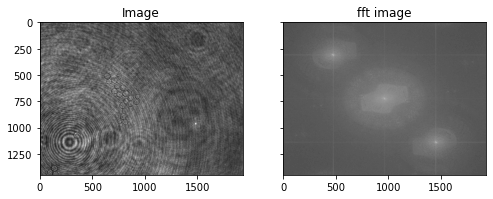

In [19]:
# Compute fft image
fftImage = np.fft.fftshift(np.fft.fft2(data))

#Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4), sharey = True)
ax1.set_title(f"Image")
ax1.imshow(data, cmap = cmap)
ax2.set_title(f"fft image")
ax2.imshow(np.log(np.abs(fftImage)), cmap = cmap)
plt.savefig(f"plots/{saveplots_name}/fftimage.png", dpi = 100, bbox_inches = 'tight')
plt.show()

C:\Users\Fredrik\AppData\Local\Temp/ipykernel_17948/64066037.py:44: RuntimeWarning: divide by zero encountered in log
  ax1.imshow(np.log(np.abs(fftImage)), cmap = cmap)


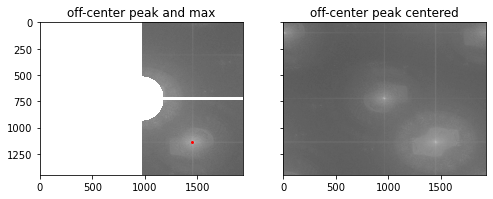

In [20]:
#Constants
yr, xr = fftImage.shape #image shape
lambda_ = 633e-9 #wavelength
k = 2 * np.pi / lambda_ # wavevector
filter_radius = 200 # Circular filtering radius

#Create meshgrid
x = np.arange(-(xr/2-1/2), (xr/2 + 1/2), 1)
y = np.arange(-(yr/2-1/2), (yr/2 + 1/2), 1)
X, Y = np.meshgrid(x, y)

#Create meshgrid for range (pi, -pi)
kx = np.linspace(-np.pi, np.pi, xr) 
ky = np.linspace(-np.pi, np.pi, yr)
KX, KY = np.meshgrid(kx, ky)

#Position matrix
position_matrix = np.sqrt(X**2 + Y**2)

# Filter out information in the fftimage that does not belong to one off the off-center peaks. We here focus on the "right" off-center peak
fftImage = np.where(position_matrix < filter_radius, 0, fftImage) 
fftImage = np.where(X < -5, 0, fftImage) 
fftImage = np.where(np.abs(Y) < 5, 0, fftImage)

#Find maximum in the extracted_region.
idx_max = np.unravel_index(np.argmax(fftImage, axis=None), fftImage.shape)

#Get value x_pos and y_pos in meshes
x_pos = X[idx_max] 
y_pos = Y[idx_max] 
dist_peak = np.sqrt(x_pos**2 + y_pos**2)

#Get value kx_pos and ky_pos in meshes
kx_pos = KX[idx_max]
ky_pos = KY[idx_max]
kx_add_ky = kx_pos*X+ky_pos*Y

# Shift the off-center peak to the centre.
fftImage2 = np.fft.fftshift(np.fft.fft2(data * np.exp(1j*(kx_add_ky))))

#Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4), sharey = True)
ax1.set_title(f"off-center peak and max")
ax1.imshow(np.log(np.abs(fftImage)), cmap = cmap)
ax1.scatter(idx_max[1], idx_max[0], color = 'red', marker = 'o', s = 4)
ax2.set_title(f"off-center peak centered")
ax2.imshow(np.log(np.abs(fftImage2)), cmap = cmap)
plt.savefig(f"plots/{saveplots_name}/fftimage_offcenter_shift.png", dpi = 100, bbox_inches = 'tight')
plt.show()

C:\Users\Fredrik\AppData\Local\Temp/ipykernel_17948/1940659479.py:25: RuntimeWarning: divide by zero encountered in log
  ax1.imshow(np.log(np.abs(fftImage2[crop_size:-crop_size, crop_size:-crop_size])), cmap = cmap)


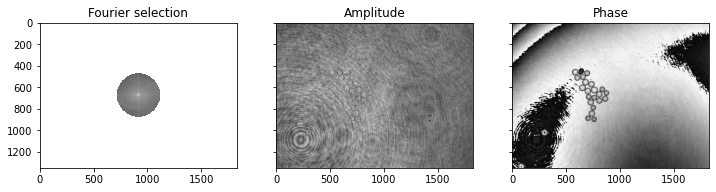

In [21]:
#3 can be changed somewhat. Effectively determines how large circular selection is.
selection_filter = position_matrix > dist_peak / 3 
crop_size = 50

#Set values outside selection filter to 0.
fftImage2 = np.where(selection_filter, 0, fftImage2)

#Scale fftimage with sinc function 
fftImage2 = fftImage2 * np.sinc(selection_filter)

### Retrieve optical field
E_field = np.fft.ifft2(np.fft.fftshift(fftImage2))
E_field = np.conj(E_field) # Depending on peak you might want to take the complex conjugate.

#Crop Optical field to avoid edge effects.
E_field_cropped = E_field[crop_size:-crop_size, crop_size:-crop_size]

#Cropping meshgrid for later use.
X_c = X[crop_size:-crop_size, crop_size:-crop_size] 
Y_c = Y[crop_size:-crop_size, crop_size:-crop_size]

#Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4), sharey = True)
ax1.set_title(f"Fourier selection")
ax1.imshow(np.log(np.abs(fftImage2[crop_size:-crop_size, crop_size:-crop_size])), cmap = cmap)
ax2.set_title(f"Amplitude")
ax2.imshow(np.abs(E_field_cropped), cmap = cmap)
ax3.set_title(f"Phase")
ax3.imshow(np.angle(E_field_cropped), cmap = cmap)
plt.savefig(f"plots/{saveplots_name}/fftimage_amplitude_phase.png", dpi = 100, bbox_inches = 'tight')
plt.show()

In [22]:
# As seen in the phase image above. We need to perform some background corrections of the phase.
# Below we show how to fit a 4th order polynomial to the phase, unwarping of the phase and other corrections.

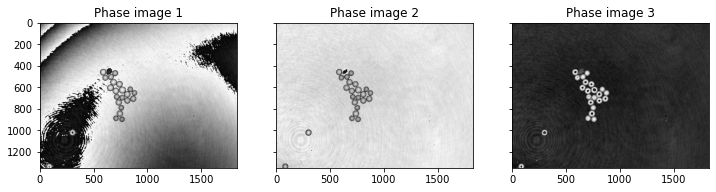

In [23]:
#Compute phase
phase_img = np.angle(E_field_cropped)

#Retrieve matrices for computing phase background.
G = Utils.get_G_matrix(phase_img.shape)
polynomial = Utils.get_4th_polynomial(phase_img.shape)

#Retrive phase background.
phase_background = Utils.correct_phase_4order(
                                            phase_img=phase_img,
                                            G = G,
                                            polynomial= polynomial
                                            )

#Correct Optical field with background
E_field_corr = E_field_cropped * np.exp( - 1j * phase_background)
phase_img2 = np.angle(E_field_corr)

#Correct Optical field with median
E_field_corr2 = E_field_corr * np.exp(- 1j * np.median(phase_img2 + np.pi - 1))
phase_img3 = np.angle(E_field_corr2)

#Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4), sharey = True)
phases = [phase_img, phase_img2, phase_img3]
for i, k in enumerate([ax1, ax2, ax3]):
    k.set_title(f"Phase image {i+1}")
    k.imshow(phases[i], cmap = cmap)
plt.savefig(f"plots/{saveplots_name}/phase_corrections_1.png", dpi = 100, bbox_inches = 'tight')
plt.show()

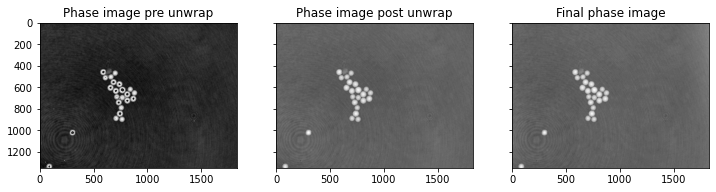

In [24]:
#Matrices for computing unwraped phase.
KY_, KX_ = np.meshgrid(np.arange(1, X_c.shape[1]+1,1), np.arange(1, X_c.shape[0]+1, 1))
KX2_add_KY2 = KX_**2+KY_**2

#Unwrap the phase. (Obs. can be quite slow.)
phase_img_unwarp = Utils.phaseunwrap(phase_img3, KX2_add_KY2)

#Fit a new background to the unwraped phase.
phi_thres = 0.5
phase_background2 = Utils.correct_phase_4order_removal(
                                                    phase_img = phase_img_unwarp,
                                                    X = X_c,
                                                    Y = Y_c,
                                                    polynomial = polynomial,
                                                    phi_thres = phi_thres
                                                    )

#Correct the unwarped phase with background subtraction
phase_img4 = phase_img_unwarp - phase_background2

#Final optical field.    
Optical_field = np.abs(E_field_corr2)*np.exp(1j * phase_img4)

#Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4), sharey = True)
ax1.set_title(f"Phase image pre unwrap")
ax1.imshow(phase_img3, cmap = cmap)
ax2.set_title(f"Phase image post unwrap")
ax2.imshow(phase_img_unwarp, cmap = cmap)
ax3.set_title(f"Final phase image")
ax3.imshow(phase_img4, cmap = cmap)
plt.savefig(f"plots/{saveplots_name}/phase_corrections2.png", dpi = 100, bbox_inches = 'tight')
plt.show()

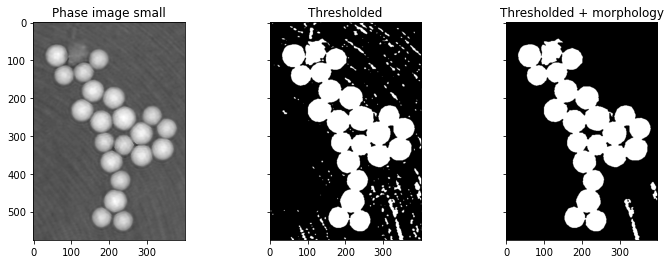

In [25]:
### Looking at a smaller region of the phase image where we have particles.

#Extract a small region with particles.
tmp = phase_img4[375:950, 525:925]

#Binary threshold image.
thres_tmp = tmp > np.median(tmp) + 0.2

#Remove small noisy stuff. Can be optimized further.
thres_tmp2 = morphology.remove_small_objects(thres_tmp, min_size=300, connectivity=4)

#Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4), sharey = True)
ax1.set_title(f"Phase image small")
ax1.imshow(tmp, cmap = cmap)
ax2.set_title(f"Thresholded")
ax2.imshow(thres_tmp, cmap = cmap)
ax3.set_title(f"Thresholded + morphology")
ax3.imshow(thres_tmp2, cmap = cmap)
plt.savefig(f"plots/{saveplots_name}/particle_analysis.png", dpi = 100, bbox_inches = 'tight')
plt.show()

In [26]:
area = np.sum(thres_tmp2)
max_phase = np.max(tmp - np.median(tmp))

n_psl = 1.59 #Refractive index psl
n_oil = 1.515 #Refractive index oil
lambda_ = 632.8 * 10e-3

#Radius in pixels.
R = max_phase / (2 * np.pi / lambda_) / (n_psl - n_oil) / 2

print(np.sqrt(np.pi * R**2 / area))


0.3241064770083708
